# 02b — Cluster UPGMA

In [1]:
from pathlib import Path
import pickle

ROOT=Path.cwd()
for c in (ROOT,*ROOT.parents):
    if (c/"outputs"/"similarity_distance.pkl").exists(): ROOT=c; break
OUT=ROOT/"outputs"
obj=pickle.load(open(OUT/"similarity_distance.pkl","rb"))
langs=obj["langs"]; Dist=obj["Dist"]; D=len(langs)
print("D:", D, "langs:", langs)

D: 16 langs: ['ilocano', 'kapampangan', 'maguindanao', 'ibanag', 'tausug', 'pangasinan', 'kankanaey', 'tagalog', 'cebuano', 'hiligaynon', 'bikol', 'maranao', 'waray', 'chavacano', 'spanish', 'english']


### Step 1: Build a hierarchical clustering tree with UPGMA (average linkage)

This step constructs a dendrogram-compatible merge history using **UPGMA** (Unweighted Pair Group Method with Arithmetic Mean) on your precomputed distance matrix `Dist`.

What the code does:
- Initializes each item as its own cluster with fields:
  - `id` (unique integer), `leaves` (indices of original items), `size` (number of leaves)
- Builds a working `dist` dictionary of pairwise distances between current cluster ids
- Repeats until only one cluster remains:
  1. `argmin(ids)` finds the closest pair of clusters `(a_id, b_id)` by scanning `dist`
  2. Merges clusters `A` and `B` into a new cluster `C` with:
     - `id = next_id`, `leaves = A.leaves + B.leaves`, `size = A.size + B.size`
     - Merge height `h` is the distance between `A` and `B` at the time of merging
  3. Updates distances to the new cluster `C` using **average linkage**:
     \[
       d(C, X) = \frac{|A| \cdot d(A, X) + |B| \cdot d(B, X)}{|A| + |B|}
     \]
  4. Removes old pairs that involve `A` or `B` from `dist`
  5. Appends the merge tuple `(A.id, B.id, h, C.id)` to `merges` for dendrogram plotting

Outputs saved:
- `upgma.pkl` contains:
  - `langs` (labels for leaves in original order)
  - `merges` (list of tuples for each merge in chronological order)

How to use `merges`:
- Each tuple `(left_id, right_id, height, new_id)` describes one step in the tree
- The final cluster id equals `D - 1 + number_of_merges` if you start ids at `0..D-1`
- You can reconstruct a dendrogram by walking the `merges` list from first to last and laying out vertical joins at `height`

Notes:
- This is a straightforward O(D³) implementation due to repeated scans for the minimum and full dictionary updates
- Works well for moderate D (tens to a few hundreds). For very large D consider a priority queue or a specialized library


In [2]:
clusters=[{"id":i,"leaves":[i],"size":1} for i in range(D)]
dist={(i,j):Dist[i][j] for i in range(D) for j in range(i+1,D)}
merges=[]; next_id=D

def argmin(ids):
    best=(None,None,1e9)
    for i in range(len(ids)):
        for j in range(i+1,len(ids)):
            a,b=ids[i],ids[j]
            d=dist.get((a,b), dist.get((b,a), 1e9))
            if d<best[2]: best=(a,b,d)
    return best

while len(clusters)>1:
    ids=[c["id"] for c in clusters]
    a_id,b_id,h=argmin(ids)
    ai=next(k for k,c in enumerate(clusters) if c["id"]==a_id)
    bi=next(k for k,c in enumerate(clusters) if c["id"]==b_id)
    A,B=clusters[ai],clusters[bi]
    C={"id":next_id,"leaves":A["leaves"]+B["leaves"],"size":A["size"]+B["size"]}
    next_id+=1
    for X in clusters:
        if X["id"] in (A["id"],B["id"]): continue
        dAX=dist.get((A["id"],X["id"]), dist.get((X["id"],A["id"])))
        dBX=dist.get((B["id"],X["id"]), dist.get((X["id"],B["id"])))
        dist[(C["id"],X["id"])]=(A["size"]*dAX + B["size"]*dBX)/(A["size"]+B["size"])
    dist={k:v for k,v in dist.items() if A["id"] not in k and B["id"] not in k}
    for idx in sorted([ai,bi], reverse=True): clusters.pop(idx)
    clusters.append(C); merges.append((A["id"],B["id"],h,C["id"]))

print("merges:", len(merges))
pickle.dump({"langs":langs,"merges":merges}, open(OUT/"upgma.pkl","wb"))
print("Saved:", OUT/"upgma.pkl")


merges: 15
Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\upgma.pkl


### Step 2: Plot the dendrogram with a smarter leaf order

This cell draws the dendrogram and improves readability by reordering leaf positions:

- Build `tree` from `merges`, identify the `root`, and set `n = len(langs)`.
- Compute each leaf's **first merge height**:
  - For every merge `(l, r, h, new)`, record the earliest height `h` where a leaf first joins another node.
  - Any leaf without a recorded merge height gets `0.0` as a fallback.
- Create an `order` of leaves by **ascending first merge height**. Ties break by original index.
  - This tends to place more closely related leaves near each other on the x axis.
  - It produces a cleaner and more interpretable layout than raw index order.
- Map each leaf to its x position based on `order`.
- Recursively compute coordinates with `layout(node)` and collect line segments.
- Plot the dendrogram:
  - x ticks are the reordered language labels
  - y axis shows the merge distance
  - Save as `dendrogram.png` in `OUT`


Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\dendrogram.png


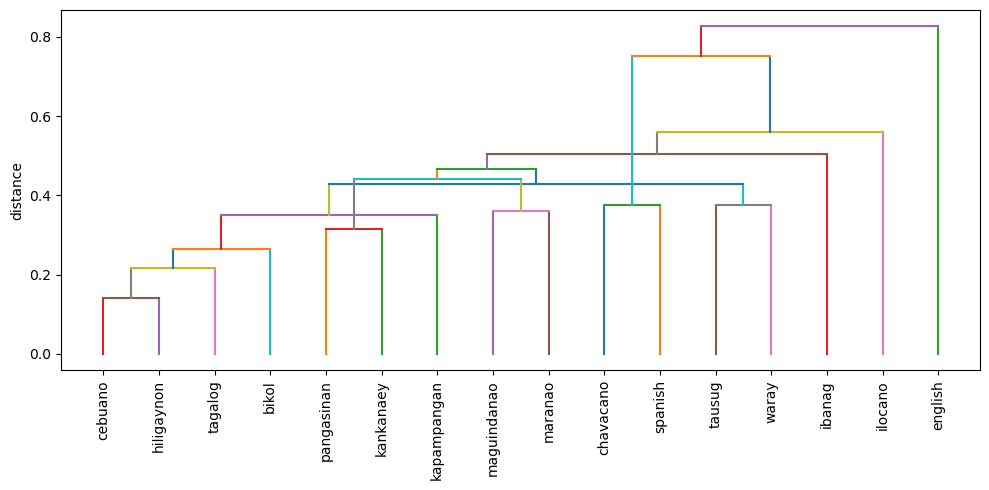

In [3]:
import matplotlib.pyplot as plt 
tree = {new: {"L": l, "R": r, "h": h} for (l, r, h, new) in merges}
root = merges[-1][3]
n = len(langs)

# compute each leaf's first-merge height, then order leaves by it
first_merge_height = {i: float('inf') for i in range(n)}
for (l, r, h, new) in merges:
    if l < n: first_merge_height[l] = min(first_merge_height[l], h)
    if r < n: first_merge_height[r] = min(first_merge_height[r], h)

# any isolated leaves (shouldn't happen) fall back to 0.0
for i in range(n):
    if first_merge_height[i] == float('inf'):
        first_merge_height[i] = 0.0

# order leaves by ascending first-merge height; tie-break by original index
order = sorted(range(n), key=lambda i: (first_merge_height[i], i))

# map leaf -> x-position according to this order
leaf_x = {leaf: x for x, leaf in enumerate(order)}

# layout & draw as before
lines = []
def layout(node):
    if node < n: return leaf_x[node], 0.0
    L, R, h = tree[node]["L"], tree[node]["R"], tree[node]["h"]
    lx, ly = layout(L); rx, ry = layout(R)
    lines.extend([((lx, ly), (lx, h)), ((rx, ry), (rx, h)), ((lx, h), (rx, h))])
    return (lx + rx) / 2, h
layout(root)
plt.figure(figsize=(10, 5))
for (x1, y1), (x2, y2) in lines: plt.plot([x1, x2], [y1, y2])
plt.xticks(range(n), [langs[i] for i in order], rotation=90)
plt.ylabel("distance")
plt.tight_layout()
plt.savefig(OUT / "dendrogram.png", dpi=200)
print("Saved:", OUT / "dendrogram.png")